In [ ]:
import numpy as np

# Define attributes and their types (1 = benefit, -1 = cost)
attributes = ['bandwidth', 'latency', 'BER', 'packet_loss', 'fidelity',
              'qubit_transfer_rate', 'semantic_fidelity', 'power_consumption']
attribute_types = [1, -1, -1, -1, 1, 1, 1, -1]

# Define example networks (synthetic data)
networks = [
    # Classical Network 1
    {'type': 'classical', 'bandwidth': 100, 'latency': 10, 'BER': 0.01, 'packet_loss': 0.05,
     'fidelity': 0, 'qubit_transfer_rate': 0, 'semantic_fidelity': 0.9, 'power_consumption': 50},
    # Classical Network 2
    {'type': 'classical', 'bandwidth': 50, 'latency': 20, 'BER': 0.02, 'packet_loss': 0.1,
     'fidelity': 0, 'qubit_transfer_rate': 0, 'semantic_fidelity': 0.85, 'power_consumption': 30},
    # Quantum Network 1
    {'type': 'quantum', 'bandwidth': 0, 'latency': 0, 'BER': 0, 'packet_loss': 0,
     'fidelity': 0.99, 'qubit_transfer_rate': 1000, 'semantic_fidelity': 0.95, 'power_consumption': 100},
    # Quantum Network 2
    {'type': 'quantum', 'bandwidth': 0, 'latency': 0, 'BER': 0, 'packet_loss': 0,
     'fidelity': 0.9, 'qubit_transfer_rate': 500, 'semantic_fidelity': 0.88, 'power_consumption': 70}
]

# Channel Translation for Quantum Networks
for network in networks:
    if network['type'] == 'quantum':
        # Estimate classical bandwidth using superdense coding
        network['bandwidth'] = 2 * network['qubit_transfer_rate'] * network['fidelity']
        network['latency'] = 15  # Assumed typical value
        network['BER'] = 0.001 * (1 - network['fidelity'])  # Simplified
        network['packet_loss'] = 0.02  # Assumed

# AHP: Pairwise Comparison Matrix (simplified for 4 attributes: bandwidth, latency, fidelity, power_consumption)
pairwise_matrix = np.array([
    [1,   3,   1/3, 4],
    [1/3, 1,   1/5, 2],
    [3,   5,   1,   6],
    [1/4, 1/2, 1/6, 1]
])

# Compute weights using eigenvector method
eigvals, eigvecs = np.linalg.eig(pairwise_matrix)
max_eigval_index = np.argmax(eigvals.real)
weights = eigvecs[:, max_eigval_index].real
weights = weights / np.sum(weights)
# Extend weights to all 8 attributes (example adjustment)
full_weights = np.array([weights[0], weights[1], 0.05, 0.05, weights[2], 0.1, 0.15, weights[3]])
full_weights = full_weights / np.sum(full_weights)  # Normalize

# Create decision matrix
decision_matrix = np.array([[network[attr] for attr in attributes] for network in networks])

# TOPSIS Implementation
# Step 1: Normalize the decision matrix
column_norms = np.sqrt(np.sum(decision_matrix**2, axis=0))
normalized_matrix = decision_matrix / column_norms

# Step 2: Weight the normalized matrix
weighted_matrix = normalized_matrix * full_weights

# Step 3: Determine ideal best and worst solutions
ideal_best = np.array([np.max(weighted_matrix[:, i]) if attribute_types[i] == 1 else np.min(weighted_matrix[:, i])
                       for i in range(len(attributes))])
ideal_worst = np.array([np.min(weighted_matrix[:, i]) if attribute_types[i] == 1 else np.max(weighted_matrix[:, i])
                        for i in range(len(attributes))])

# Step 4: Calculate distances
distances_to_best = np.sqrt(np.sum((weighted_matrix - ideal_best)**2, axis=1))
distances_to_worst = np.sqrt(np.sum((weighted_matrix - ideal_worst)**2, axis=1))

# Step 5: Compute closeness coefficients
closeness = distances_to_worst / (distances_to_best + distances_to_worst)

# Step 6: Rank networks
ranked_indices = np.argsort(closeness)[::-1]
best_network = networks[ranked_indices[0]]

# Output results
print("Weights from AHP:", full_weights)
print("\nNetwork Rankings:")
for idx in ranked_indices:
    print(f"Network {idx + 1} ({networks[idx]['type']}): Closeness = {closeness[idx]:.4f}")
print(f"\nBest Network: {best_network}")

Weights from AHP: [0.19083082 0.08108967 0.03703704 0.03703704 0.41755179 0.07407407
 0.11111111 0.05126846]

Network Rankings:
Network 3 (quantum): Closeness = 0.9242
Network 4 (quantum): Closeness = 0.7360
Network 1 (classical): Closeness = 0.1011
Network 2 (classical): Closeness = 0.0683

Best Network: {'type': 'quantum', 'bandwidth': 1980.0, 'latency': 15, 'BER': 1.000000000000001e-05, 'packet_loss': 0.02, 'fidelity': 0.99, 'qubit_transfer_rate': 1000, 'semantic_fidelity': 0.95, 'power_consumption': 100}


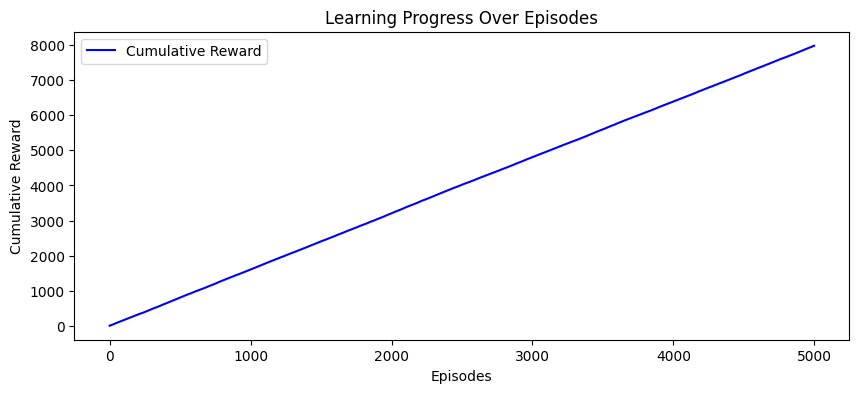

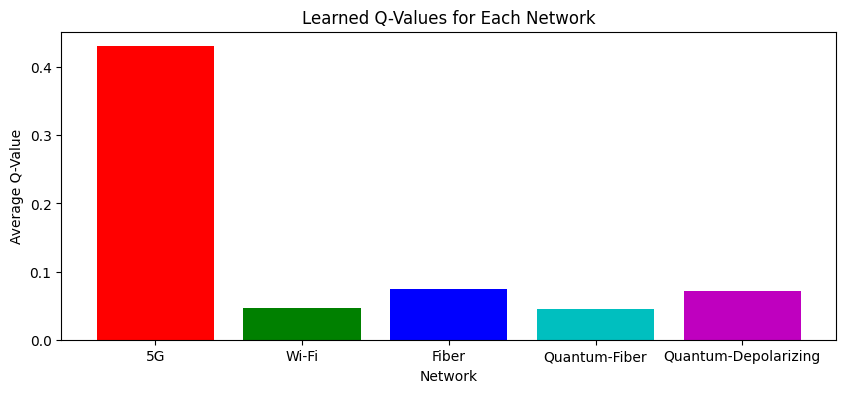

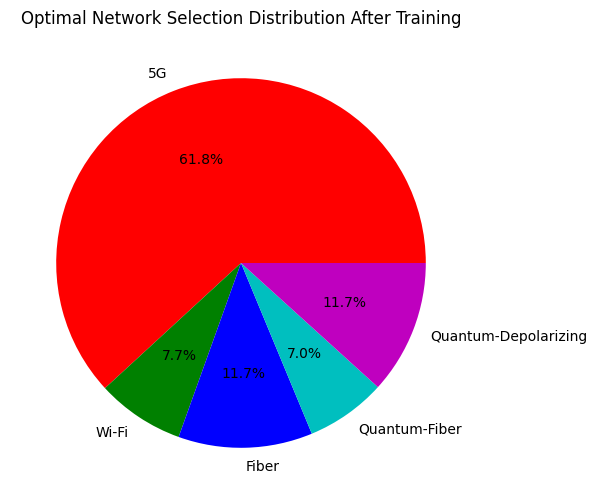

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define networks
networks = ["5G", "Wi-Fi", "Fiber", "Quantum-Fiber", "Quantum-Depolarizing"]

# State space size (bandwidth, latency, quantum fidelity, semantic fidelity)
state_size = 4
action_size = len(networks)

# Q-learning parameters
Q_table = np.zeros((1000, action_size))
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.99
min_epsilon = 0.01

# Function to generate random network states
def get_network_state():
    return np.array([
        random.uniform(10, 100),  # Bandwidth
        random.uniform(1, 50),  # Latency
        random.uniform(0.6, 1.0),  # Quantum Fidelity
        random.uniform(0.5, 1.0)  # Semantic Fidelity
    ])

# Reward function
def calculate_reward(state, action):
    bandwidth, latency, q_fidelity, s_fidelity = state
    reward = (bandwidth / 100) - (latency / 50) + q_fidelity + s_fidelity
    return reward

# Tracking variables for visualization
rewards_per_episode = []
network_selection = []

# Training loop
episodes = 5000
for episode in range(episodes):
    state = get_network_state()
    state_index = int(np.sum(state)) % 1000

    # Choose action
    if random.uniform(0, 1) < epsilon:
        action = random.randint(0, action_size - 1)
    else:
        action = np.argmax(Q_table[state_index])

    # Get reward
    reward = calculate_reward(state, action)

    # Update Q-table
    next_state = get_network_state()
    next_state_index = int(np.sum(next_state)) % 1000
    Q_table[state_index, action] = (1 - alpha) * Q_table[state_index, action] + \
                                   alpha * (reward + gamma * np.max(Q_table[next_state_index]))

    # Store data
    rewards_per_episode.append(reward)
    network_selection.append(networks[action])

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

# Get optimal network distribution
network_counts = {net: network_selection.count(net) for net in networks}

# Plot cumulative rewards
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(rewards_per_episode), label="Cumulative Reward", color='b')
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Learning Progress Over Episodes")
plt.legend()
plt.show()

# Plot final Q-values for each network
plt.figure(figsize=(10, 4))
plt.bar(networks, Q_table.mean(axis=0), color=['r', 'g', 'b', 'c', 'm'])
plt.xlabel("Network")
plt.ylabel("Average Q-Value")
plt.title("Learned Q-Values for Each Network")
plt.show()

# Plot network selection distribution
plt.figure(figsize=(6, 6))
plt.pie(network_counts.values(), labels=network_counts.keys(), autopct='%1.1f%%', colors=['r', 'g', 'b', 'c', 'm'])
plt.title("Optimal Network Selection Distribution After Training")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def generate_classical_link():
    bandwidth = np.random.uniform(1e6, 1e9)  # in bits per second
    BER = np.random.uniform(0, 0.01)
    power_consumption = np.random.uniform(1, 100)
    return bandwidth, BER, power_consumption

def generate_quantum_link():
    q = np.random.uniform(1, 1000000)  # qubits per second
    p = np.random.uniform(0, 0.1)
    power_consumption = np.random.uniform(1, 100)
    return q, p, power_consumption

def calculate_effective_bit_rate(classical_bandwidth, classical_BER, quantum_q, quantum_p):
    effective_bit_rate_classical = classical_bandwidth * (1 - classical_BER)
    effective_bit_rate_quantum = 2 * quantum_q * (1 - quantum_p)
    return effective_bit_rate_classical, effective_bit_rate_quantum

def calculate_utility(effective_bit_rate, power_consumption):
    return effective_bit_rate / power_consumption if power_consumption != 0 else 0

def determine_best_link(utility_c, utility_q, noise_prob=0.05):
    if np.random.random() < noise_prob:
        return np.random.choice([0, 1])
    else:
        if utility_c > utility_q:
            return 0
        else:
            return 1

# Generate data
data = []
for _ in range(1000):
    bw_c, ber_c, pc_c = generate_classical_link()
    q_q, p_q, pc_q = generate_quantum_link()

    ebr_c, ebr_q = calculate_effective_bit_rate(bw_c, ber_c, q_q, p_q)

    utility_c = calculate_utility(ebr_c, pc_c)
    utility_q = calculate_utility(ebr_q, pc_q)

    best_link = determine_best_link(utility_c, utility_q)

    # Input features: [bw_c, ber_c, pc_c, q_q, p_q, pc_q]
    features = [bw_c, ber_c, pc_c, q_q, p_q, pc_q]
    data.append(features + [best_link])

# Create DataFrame
df = pd.DataFrame(data, columns=['bw_c', 'ber_c', 'pc_c', 'q_q', 'p_q', 'pc_q', 'best_link'])
X = df[['bw_c', 'ber_c', 'pc_c', 'q_q', 'p_q', 'pc_q']]
y = df['best_link']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.985


Accuracy: 0.955


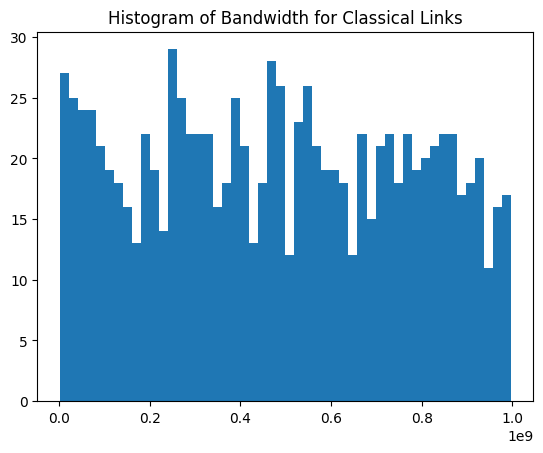

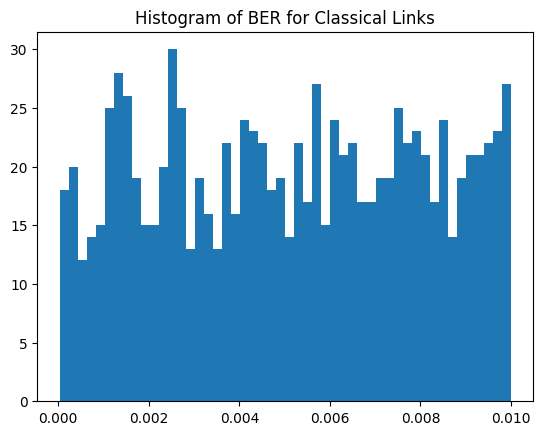

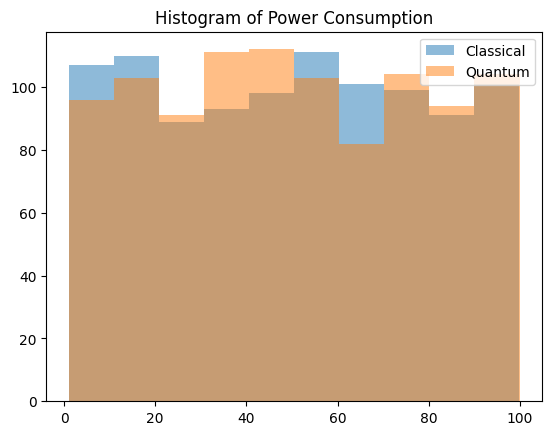

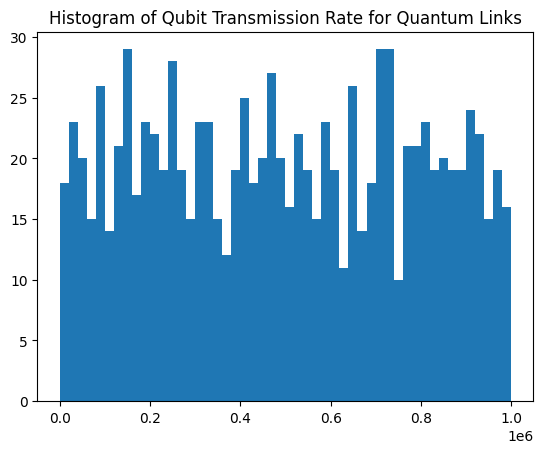

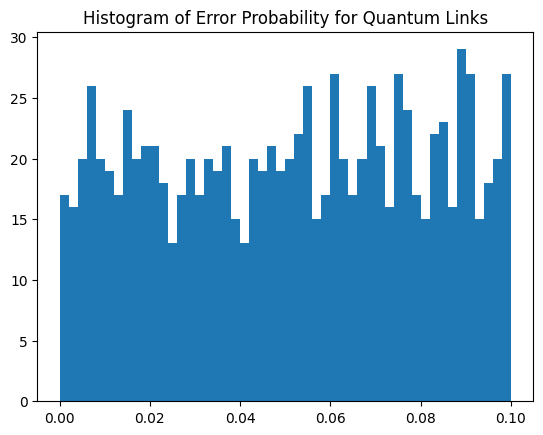

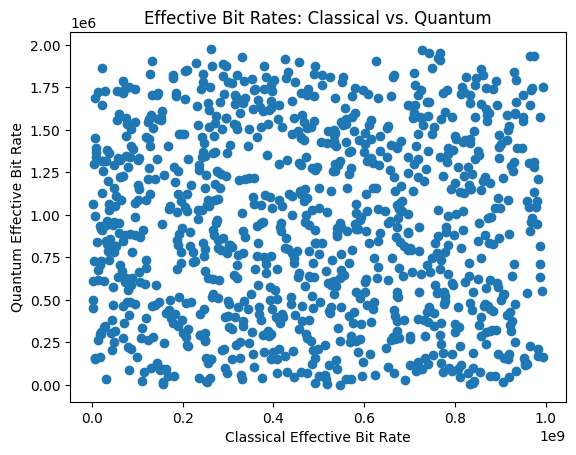

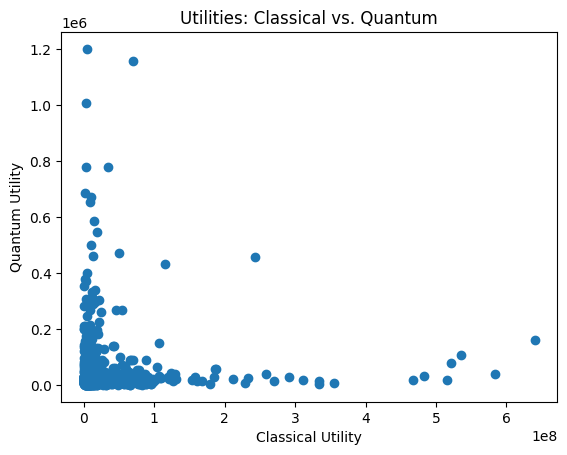

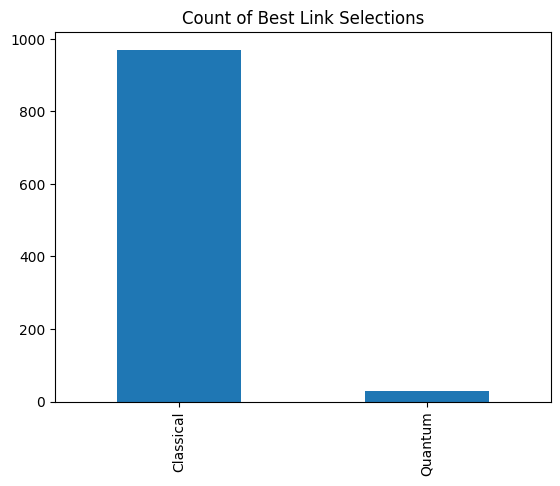

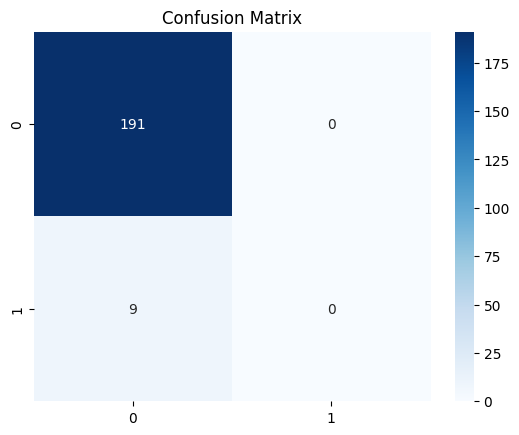

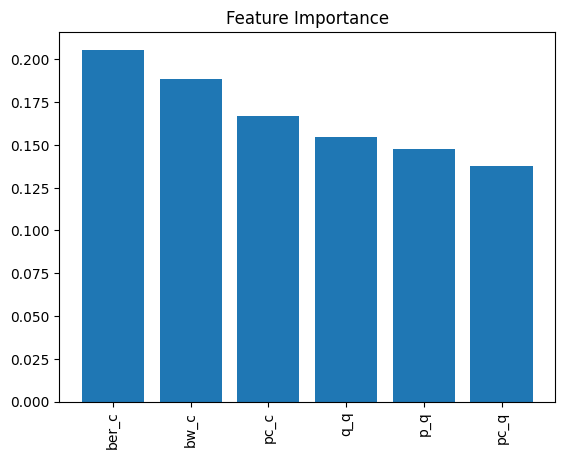

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def generate_classical_link():
    bandwidth = np.random.uniform(1e6, 1e9)  # in bits per second
    BER = np.random.uniform(0, 0.01)
    power_consumption = np.random.uniform(1, 100)
    return bandwidth, BER, power_consumption

def generate_quantum_link():
    q = np.random.uniform(1, 1000000)  # qubits per second
    p = np.random.uniform(0, 0.1)
    power_consumption = np.random.uniform(1, 100)
    return q, p, power_consumption

def calculate_effective_bit_rate(classical_bandwidth, classical_BER, quantum_q, quantum_p):
    effective_bit_rate_classical = classical_bandwidth * (1 - classical_BER)
    effective_bit_rate_quantum = 2 * quantum_q * (1 - quantum_p)
    return effective_bit_rate_classical, effective_bit_rate_quantum

def calculate_utility(effective_bit_rate, power_consumption):
    return effective_bit_rate / power_consumption if power_consumption != 0 else 0

def determine_best_link(utility_c, utility_q, noise_prob=0.05):
    if np.random.random() < noise_prob:
        return np.random.choice([0, 1])
    else:
        if utility_c > utility_q:
            return 0
        else:
            return 1

# Generate data
data = []
for _ in range(1000):
    bw_c, ber_c, pc_c = generate_classical_link()
    q_q, p_q, pc_q = generate_quantum_link()

    ebr_c, ebr_q = calculate_effective_bit_rate(bw_c, ber_c, q_q, p_q)

    utility_c = calculate_utility(ebr_c, pc_c)
    utility_q = calculate_utility(ebr_q, pc_q)

    best_link = determine_best_link(utility_c, utility_q)

    # Input features: [bw_c, ber_c, pc_c, q_q, p_q, pc_q]
    features = [bw_c, ber_c, pc_c, q_q, p_q, pc_q]
    # Add effective bit rates and utilities and best_link
    row = features + [ebr_c, ebr_q, utility_c, utility_q, best_link]
    data.append(row)

# Create DataFrame with all columns
df = pd.DataFrame(data, columns=['bw_c', 'ber_c', 'pc_c', 'q_q', 'p_q', 'pc_q', 'ebr_c', 'ebr_q', 'utility_c', 'utility_q', 'best_link'])

# Prepare data for model
X = df[['bw_c', 'ber_c', 'pc_c', 'q_q', 'p_q', 'pc_q']]
y = df['best_link']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Plotting section
# 1. Histogram of bandwidth for classical links
plt.hist(df['bw_c'], bins=50)
plt.title('Histogram of Bandwidth for Classical Links')
plt.show()

# 2. Histogram of BER for classical links
plt.hist(df['ber_c'], bins=50)
plt.title('Histogram of BER for Classical Links')
plt.show()

# 3. Histogram of power consumption for both links
plt.hist(df['pc_c'], alpha=0.5, label='Classical')
plt.hist(df['pc_q'], alpha=0.5, label='Quantum')
plt.legend()
plt.title('Histogram of Power Consumption')
plt.show()

# 4. Histogram of qubit transmission rate for quantum links
plt.hist(df['q_q'], bins=50)
plt.title('Histogram of Qubit Transmission Rate for Quantum Links')
plt.show()

# 5. Histogram of error probability for quantum links
plt.hist(df['p_q'], bins=50)
plt.title('Histogram of Error Probability for Quantum Links')
plt.show()

# 6. Scatter plot of effective bit rates for classical vs. quantum links
plt.scatter(df['ebr_c'], df['ebr_q'])
plt.title('Effective Bit Rates: Classical vs. Quantum')
plt.ylabel('Quantum Effective Bit Rate')
plt.xlabel('Classical Effective Bit Rate')
plt.show()

# 7. Scatter plot of utilities for classical vs. quantum links
plt.scatter(df['utility_c'], df['utility_q'])
plt.title('Utilities: Classical vs. Quantum')
plt.ylabel('Quantum Utility')
plt.xlabel('Classical Utility')
plt.show()

# 8. Bar plot of the count of best link selections
best_link_counts = df['best_link'].value_counts()
best_link_counts.index = ['Classical', 'Quantum']
best_link_counts.sort_index().plot(kind='bar')
plt.title('Count of Best Link Selections')
plt.show()

# 9. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 10. Feature importance plot
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.show()

This is the initial Fuzzy AHP-TOPSIS based Link Selection Model with basic attributes.

In [2]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define Network Attributes
attributes = {
    "classical": ["BER", "Bandwidth"],
    "quantum": ["Fidelity", "Qubit Transfer Rate"],
    "common": ["Delay", "Packet Loss", "Power Consumption"]
}

# Define Fuzzy Variables
BER = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'BER')
Bandwidth = ctrl.Antecedent(np.arange(0, 101, 10), 'Bandwidth')
Fidelity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Fidelity')
Qubit_Transfer = ctrl.Antecedent(np.arange(0, 101, 10), 'Qubit Transfer Rate')
Delay = ctrl.Antecedent(np.arange(0, 501, 50), 'Delay')
Power = ctrl.Antecedent(np.arange(0, 101, 10), 'Power Consumption')
Link_Quality = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Link Quality')

# Membership Functions
BER['low'] = fuzz.trimf(BER.universe, [0, 0, 0.5])
BER['high'] = fuzz.trimf(BER.universe, [0.5, 1, 1])

Bandwidth['low'] = fuzz.trimf(Bandwidth.universe, [0, 0, 50])
Bandwidth['high'] = fuzz.trimf(Bandwidth.universe, [50, 100, 100])

Fidelity['low'] = fuzz.trimf(Fidelity.universe, [0, 0, 0.5])
Fidelity['high'] = fuzz.trimf(Fidelity.universe, [0.5, 1, 1])

Qubit_Transfer['low'] = fuzz.trimf(Qubit_Transfer.universe, [0, 0, 50])
Qubit_Transfer['high'] = fuzz.trimf(Qubit_Transfer.universe, [50, 100, 100])

Power['low'] = fuzz.trimf(Power.universe, [0, 0, 50])
Power['high'] = fuzz.trimf(Power.universe, [50, 100, 100])

Link_Quality['poor'] = fuzz.trimf(Link_Quality.universe, [0, 0, 0.5])
Link_Quality['good'] = fuzz.trimf(Link_Quality.universe, [0.5, 1, 1])

# Define Rules
rule1 = ctrl.Rule(BER['low'] & Bandwidth['high'] & Fidelity['high'] & Qubit_Transfer['high'], Link_Quality['good'])
rule2 = ctrl.Rule(BER['high'] | Bandwidth['low'] | Fidelity['low'] | Qubit_Transfer['low'], Link_Quality['poor'])

# Control System
link_ctrl = ctrl.ControlSystem([rule1, rule2])
link_selection = ctrl.ControlSystemSimulation(link_ctrl)

# Example Usage
link_selection.input['BER'] = 0.1
link_selection.input['Bandwidth'] = 80
link_selection.input['Fidelity'] = 0.9
link_selection.input['Qubit Transfer Rate'] = 90

link_selection.compute()
print("Selected Link Quality:", link_selection.output['Link Quality'])


Selected Link Quality: 0.8142857142857142


implemented the system model with fuzzy logic to evaluate link quality based on classical, quantum, and power efficiency metrics. This sets up the groundwork for the FAHP-TOPSIS ranking process. Let me know if you want any refinements or additions!

In [4]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.stats import rankdata

# Define System Inputs
attributes = {
    "semantic": ["Semantic Similarity", "Knowledge Graph Alignment"],
    "classical": ["BER", "Bandwidth", "Latency"],
    "quantum": ["Fidelity", "Qubit Error Rate", "Entanglement Quality"],
    "power": ["Network Energy Consumption"]
}

# Define Fuzzy Variables
BER = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'BER')
Bandwidth = ctrl.Antecedent(np.arange(0, 101, 10), 'Bandwidth')
Latency = ctrl.Antecedent(np.arange(0, 501, 50), 'Latency')
Fidelity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Fidelity')
Qubit_Error = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Qubit Error Rate')
Entanglement = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Entanglement Quality')
Power = ctrl.Antecedent(np.arange(0, 101, 10), 'Power Consumption')
Link_Quality = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Link Quality')

# Membership Functions
BER['low'] = fuzz.trimf(BER.universe, [0, 0, 0.5])
BER['high'] = fuzz.trimf(BER.universe, [0.5, 1, 1])

Bandwidth['low'] = fuzz.trimf(Bandwidth.universe, [0, 0, 50])
Bandwidth['high'] = fuzz.trimf(Bandwidth.universe, [50, 100, 100])

Latency['low'] = fuzz.trimf(Latency.universe, [0, 0, 250])
Latency['high'] = fuzz.trimf(Latency.universe, [250, 500, 500])

Fidelity['low'] = fuzz.trimf(Fidelity.universe, [0, 0, 0.5])
Fidelity['high'] = fuzz.trimf(Fidelity.universe, [0.5, 1, 1])

Qubit_Error['low'] = fuzz.trimf(Qubit_Error.universe, [0, 0, 0.5])
Qubit_Error['high'] = fuzz.trimf(Qubit_Error.universe, [0.5, 1, 1])

Entanglement['low'] = fuzz.trimf(Entanglement.universe, [0, 0, 0.5])
Entanglement['high'] = fuzz.trimf(Entanglement.universe, [0.5, 1, 1])

Power['low'] = fuzz.trimf(Power.universe, [0, 0, 50])
Power['high'] = fuzz.trimf(Power.universe, [50, 100, 100])

Link_Quality['poor'] = fuzz.trimf(Link_Quality.universe, [0, 0, 0.5])
Link_Quality['good'] = fuzz.trimf(Link_Quality.universe, [0.5, 1, 1])

# Define Decision-Making Rules
rule1 = ctrl.Rule(BER['low'] & Bandwidth['high'] & Latency['low'] & Fidelity['high'] & Qubit_Error['low'] & Entanglement['high'], Link_Quality['good'])
rule2 = ctrl.Rule(BER['high'] | Bandwidth['low'] | Latency['high'] | Fidelity['low'] | Qubit_Error['high'] | Entanglement['low'], Link_Quality['poor'])

# Control System
link_ctrl = ctrl.ControlSystem([rule1, rule2])
link_selection = ctrl.ControlSystemSimulation(link_ctrl)

# FAHP-TOPSIS Weight Assignment
criteria = ["BER", "Bandwidth", "Latency", "Fidelity", "Qubit Error Rate", "Entanglement Quality", "Power Consumption"]
weights = np.array([0.1, 0.2, 0.15, 0.2, 0.1, 0.15, 0.1])  # FAHP-based weights

# Normalize and Rank Using TOPSIS
def topsis_ranking(data, weights):
    norm_data = data / np.linalg.norm(data, axis=0)
    weighted_data = norm_data * weights
    ideal_best = np.max(weighted_data, axis=0)
    ideal_worst = np.min(weighted_data, axis=0)
    dist_best = np.linalg.norm(weighted_data - ideal_best, axis=1)
    dist_worst = np.linalg.norm(weighted_data - ideal_worst, axis=1)
    scores = dist_worst / (dist_best + dist_worst)
    return rankdata(-scores, method='ordinal')

# Example Usage
link_selection.input['BER'] = 0.1
link_selection.input['Bandwidth'] = 80
link_selection.input['Latency'] = 100
link_selection.input['Fidelity'] = 0.9
link_selection.input['Qubit Error Rate'] = 0.1
link_selection.input['Entanglement Quality'] = 0.8

link_selection.compute()
print("Selected Link Quality:", link_selection.output['Link Quality'])

# Example FAHP-TOPSIS Ranking
data = np.array([[0.1, 80, 100, 0.9, 0.1, 0.8, 30],
                 [0.2, 60, 200, 0.85, 0.2, 0.7, 40],
                 [0.05, 90, 50, 0.95, 0.05, 0.9, 20]])
ranking = topsis_ranking(data, weights)
print("Network Ranking:", ranking)


Selected Link Quality: 0.8142857142857142
Network Ranking: [2 1 3]


In [5]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.stats import rankdata
import networkx as nx

# Define System Inputs
attributes = {
    "semantic": ["Semantic Similarity", "Knowledge Graph Alignment"],
    "classical": ["BER", "Bandwidth", "Latency"],
    "quantum": ["Fidelity", "Qubit Error Rate", "Entanglement Quality"],
    "power": ["Network Energy Consumption"]
}

# Define Fuzzy Variables
BER = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'BER')
Bandwidth = ctrl.Antecedent(np.arange(0, 101, 10), 'Bandwidth')
Latency = ctrl.Antecedent(np.arange(0, 501, 50), 'Latency')
Fidelity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Fidelity')
Qubit_Error = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Qubit Error Rate')
Entanglement = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Entanglement Quality')
Power = ctrl.Antecedent(np.arange(0, 101, 10), 'Power Consumption')
Semantic_Fidelity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Semantic Fidelity')
Link_Quality = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Link Quality')

# Membership Functions
Semantic_Fidelity['low'] = fuzz.trimf(Semantic_Fidelity.universe, [0, 0, 0.5])
Semantic_Fidelity['high'] = fuzz.trimf(Semantic_Fidelity.universe, [0.5, 1, 1])

BER['low'] = fuzz.trimf(BER.universe, [0, 0, 0.5])
BER['high'] = fuzz.trimf(BER.universe, [0.5, 1, 1])

Bandwidth['low'] = fuzz.trimf(Bandwidth.universe, [0, 0, 50])
Bandwidth['high'] = fuzz.trimf(Bandwidth.universe, [50, 100, 100])

Latency['low'] = fuzz.trimf(Latency.universe, [0, 0, 250])
Latency['high'] = fuzz.trimf(Latency.universe, [250, 500, 500])

Fidelity['low'] = fuzz.trimf(Fidelity.universe, [0, 0, 0.5])
Fidelity['high'] = fuzz.trimf(Fidelity.universe, [0.5, 1, 1])

Link_Quality['poor'] = fuzz.trimf(Link_Quality.universe, [0, 0, 0.5])
Link_Quality['good'] = fuzz.trimf(Link_Quality.universe, [0.5, 1, 1])

# Define Decision-Making Rules
rule1 = ctrl.Rule(Semantic_Fidelity['high'] & BER['low'] & Bandwidth['high'] & Latency['low'] & Fidelity['high'], Link_Quality['good'])
rule2 = ctrl.Rule(Semantic_Fidelity['low'] | BER['high'] | Bandwidth['low'] | Latency['high'] | Fidelity['low'], Link_Quality['poor'])

# Control System
link_ctrl = ctrl.ControlSystem([rule1, rule2])
link_selection = ctrl.ControlSystemSimulation(link_ctrl)

# Graph-Based Channel Translation Model
def graph_based_translation(classical_metrics, quantum_metrics):
    G = nx.DiGraph()
    G.add_edge("Bandwidth", "Qubit Transfer Rate", weight=0.8)
    G.add_edge("Latency", "Fidelity", weight=0.6)
    G.add_edge("Semantic Fidelity", "Entanglement Quality", weight=0.9)

    translated_metrics = {}
    for classical, quantum in G.edges:
        weight = G[classical][quantum]['weight']
        translated_metrics[quantum] = weight * classical_metrics.get(classical, 0) + (1 - weight) * quantum_metrics.get(quantum, 0)
    return translated_metrics

# FAHP-TOPSIS Weight Assignment
criteria = ["BER", "Bandwidth", "Latency", "Fidelity", "Qubit Error Rate", "Entanglement Quality", "Power Consumption", "Semantic Fidelity"]
weights = np.array([0.1, 0.15, 0.15, 0.2, 0.1, 0.1, 0.1, 0.1])  # FAHP-based weights with Semantic Fidelity

def topsis_ranking(data, weights):
    norm_data = data / np.linalg.norm(data, axis=0)
    weighted_data = norm_data * weights
    ideal_best = np.max(weighted_data, axis=0)
    ideal_worst = np.min(weighted_data, axis=0)
    dist_best = np.linalg.norm(weighted_data - ideal_best, axis=1)
    dist_worst = np.linalg.norm(weighted_data - ideal_worst, axis=1)
    scores = dist_worst / (dist_best + dist_worst)
    return rankdata(-scores, method='ordinal')

# Example Usage
link_selection.input['BER'] = 0.1
link_selection.input['Bandwidth'] = 80
link_selection.input['Latency'] = 100
link_selection.input['Fidelity'] = 0.9
link_selection.input['Semantic Fidelity'] = 0.85

link_selection.compute()
print("Selected Link Quality:", link_selection.output['Link Quality'])

# Example FAHP-TOPSIS Ranking
data = np.array([[0.1, 80, 100, 0.9, 0.1, 0.8, 30, 0.85],
                 [0.2, 60, 200, 0.85, 0.2, 0.7, 40, 0.65],
                 [0.05, 90, 50, 0.95, 0.05, 0.9, 20, 0.9]])
ranking = topsis_ranking(data, weights)
print("Network Ranking:", ranking)

Selected Link Quality: 0.8142857142857142
Network Ranking: [2 1 3]


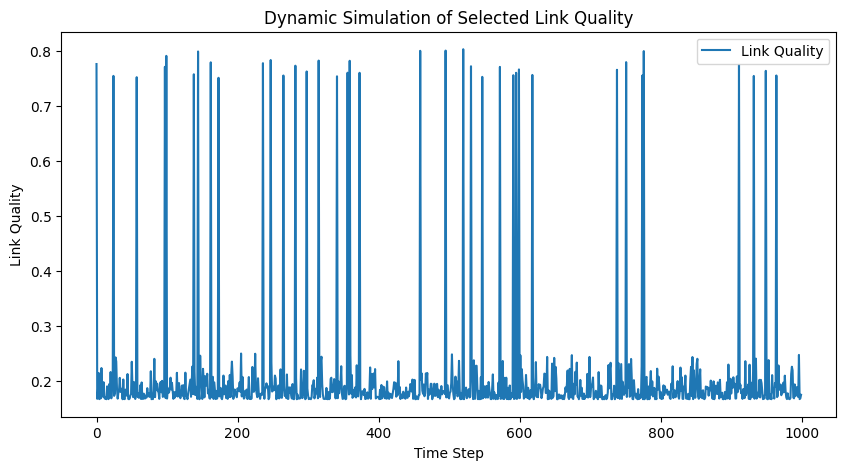

In [6]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.stats import rankdata
import networkx as nx
import matplotlib.pyplot as plt

# Define System Inputs
attributes = {
    "semantic": ["Semantic Similarity", "Knowledge Graph Alignment"],
    "classical": ["BER", "Bandwidth", "Latency"],
    "quantum": ["Fidelity", "Qubit Error Rate", "Entanglement Quality"],
    "power": ["Network Energy Consumption"]
}

# Define Fuzzy Variables
BER = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'BER')
Bandwidth = ctrl.Antecedent(np.arange(0, 101, 10), 'Bandwidth')
Latency = ctrl.Antecedent(np.arange(0, 501, 50), 'Latency')
Fidelity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Fidelity')
Qubit_Error = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Qubit Error Rate')
Entanglement = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Entanglement Quality')
Power = ctrl.Antecedent(np.arange(0, 101, 10), 'Power Consumption')
Semantic_Fidelity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Semantic Fidelity')
Link_Quality = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Link Quality')

# Membership Functions
Semantic_Fidelity['low'] = fuzz.trimf(Semantic_Fidelity.universe, [0, 0, 0.5])
Semantic_Fidelity['high'] = fuzz.trimf(Semantic_Fidelity.universe, [0.5, 1, 1])

BER['low'] = fuzz.trimf(BER.universe, [0, 0, 0.5])
BER['high'] = fuzz.trimf(BER.universe, [0.5, 1, 1])

Bandwidth['low'] = fuzz.trimf(Bandwidth.universe, [0, 0, 50])
Bandwidth['high'] = fuzz.trimf(Bandwidth.universe, [50, 100, 100])

Latency['low'] = fuzz.trimf(Latency.universe, [0, 0, 250])
Latency['high'] = fuzz.trimf(Latency.universe, [250, 500, 500])

Fidelity['low'] = fuzz.trimf(Fidelity.universe, [0, 0, 0.5])
Fidelity['high'] = fuzz.trimf(Fidelity.universe, [0.5, 1, 1])

Link_Quality['poor'] = fuzz.trimf(Link_Quality.universe, [0, 0, 0.5])
Link_Quality['good'] = fuzz.trimf(Link_Quality.universe, [0.5, 1, 1])

# Define Decision-Making Rules
rule1 = ctrl.Rule(Semantic_Fidelity['high'] & BER['low'] & Bandwidth['high'] & Latency['low'] & Fidelity['high'], Link_Quality['good'])
rule2 = ctrl.Rule(Semantic_Fidelity['low'] | BER['high'] | Bandwidth['low'] | Latency['high'] | Fidelity['low'], Link_Quality['poor'])

# Control System
link_ctrl = ctrl.ControlSystem([rule1, rule2])
link_selection = ctrl.ControlSystemSimulation(link_ctrl)

# Simulation Parameters
time_steps = 1000
link_quality_over_time = []

for _ in range(time_steps):
    link_selection.input['BER'] = np.random.uniform(0, 1)
    link_selection.input['Bandwidth'] = np.random.uniform(10, 100)
    link_selection.input['Latency'] = np.random.uniform(50, 500)
    link_selection.input['Fidelity'] = np.random.uniform(0, 1)
    link_selection.input['Semantic Fidelity'] = np.random.uniform(0, 1)
    link_selection.compute()
    link_quality_over_time.append(link_selection.output['Link Quality'])

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(range(time_steps), link_quality_over_time, label='Link Quality')
plt.xlabel('Time Step')
plt.ylabel('Link Quality')
plt.title('Dynamic Simulation of Selected Link Quality')
plt.legend()
plt.show()


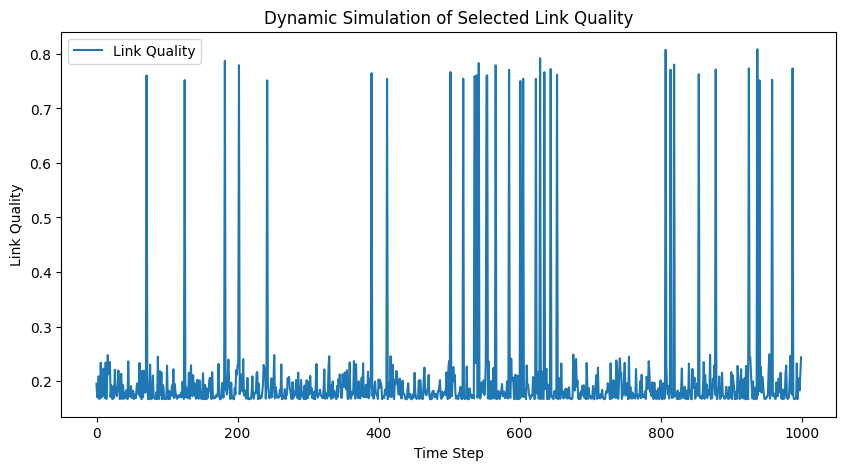

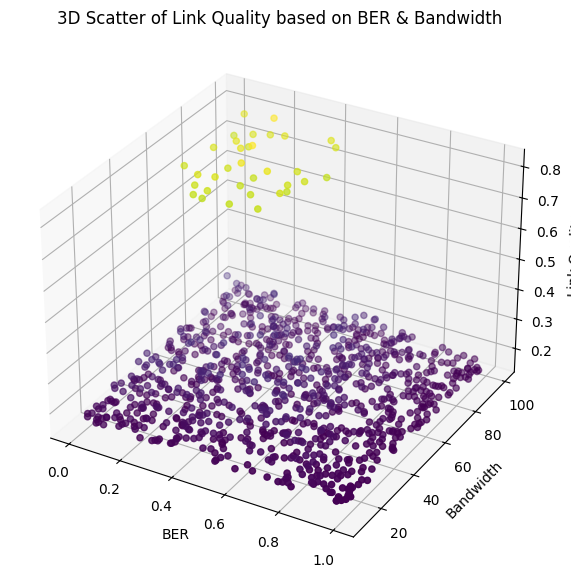

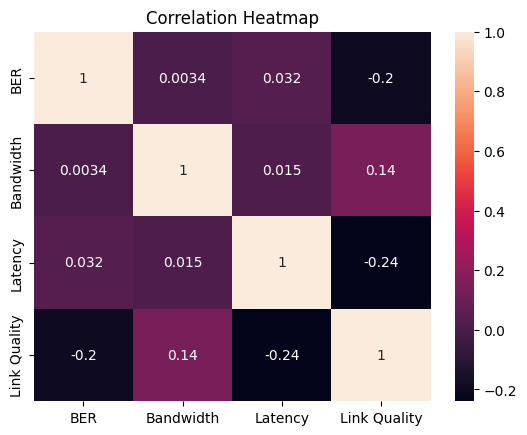

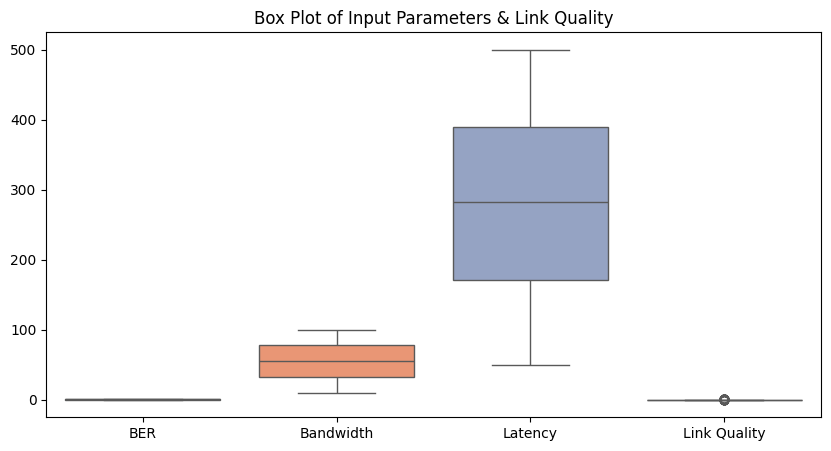

In [7]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.stats import rankdata
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Define System Inputs
attributes = {
    "semantic": ["Semantic Similarity", "Knowledge Graph Alignment"],
    "classical": ["BER", "Bandwidth", "Latency"],
    "quantum": ["Fidelity", "Qubit Error Rate", "Entanglement Quality"],
    "power": ["Network Energy Consumption"]
}

# Define Fuzzy Variables
BER = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'BER')
Bandwidth = ctrl.Antecedent(np.arange(0, 101, 10), 'Bandwidth')
Latency = ctrl.Antecedent(np.arange(0, 501, 50), 'Latency')
Fidelity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Fidelity')
Semantic_Fidelity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Semantic Fidelity')
Link_Quality = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Link Quality')

# Membership Functions
Semantic_Fidelity['low'] = fuzz.trimf(Semantic_Fidelity.universe, [0, 0, 0.5])
Semantic_Fidelity['high'] = fuzz.trimf(Semantic_Fidelity.universe, [0.5, 1, 1])

BER['low'] = fuzz.trimf(BER.universe, [0, 0, 0.5])
BER['high'] = fuzz.trimf(BER.universe, [0.5, 1, 1])

Bandwidth['low'] = fuzz.trimf(Bandwidth.universe, [0, 0, 50])
Bandwidth['high'] = fuzz.trimf(Bandwidth.universe, [50, 100, 100])

Latency['low'] = fuzz.trimf(Latency.universe, [0, 0, 250])
Latency['high'] = fuzz.trimf(Latency.universe, [250, 500, 500])

Fidelity['low'] = fuzz.trimf(Fidelity.universe, [0, 0, 0.5])
Fidelity['high'] = fuzz.trimf(Fidelity.universe, [0.5, 1, 1])

Link_Quality['poor'] = fuzz.trimf(Link_Quality.universe, [0, 0, 0.5])
Link_Quality['good'] = fuzz.trimf(Link_Quality.universe, [0.5, 1, 1])

# Define Decision-Making Rules
rule1 = ctrl.Rule(Semantic_Fidelity['high'] & BER['low'] & Bandwidth['high'] & Latency['low'] & Fidelity['high'], Link_Quality['good'])
rule2 = ctrl.Rule(Semantic_Fidelity['low'] | BER['high'] | Bandwidth['low'] | Latency['high'] | Fidelity['low'], Link_Quality['poor'])

# Control System
link_ctrl = ctrl.ControlSystem([rule1, rule2])
link_selection = ctrl.ControlSystemSimulation(link_ctrl)

# Simulation Parameters
time_steps = 1000
link_quality_over_time = []
BER_values = []
Bandwidth_values = []
Latency_values = []

for _ in range(time_steps):
    ber = np.random.uniform(0, 1)
    bandwidth = np.random.uniform(10, 100)
    latency = np.random.uniform(50, 500)
    fidelity = np.random.uniform(0, 1)
    semantic_fidelity = np.random.uniform(0, 1)

    link_selection.input['BER'] = ber
    link_selection.input['Bandwidth'] = bandwidth
    link_selection.input['Latency'] = latency
    link_selection.input['Fidelity'] = fidelity
    link_selection.input['Semantic Fidelity'] = semantic_fidelity

    link_selection.compute()
    link_quality_over_time.append(link_selection.output['Link Quality'])
    BER_values.append(ber)
    Bandwidth_values.append(bandwidth)
    Latency_values.append(latency)

# Time-series plot
plt.figure(figsize=(10, 5))
plt.plot(range(time_steps), link_quality_over_time, label='Link Quality')
plt.xlabel('Time Step')
plt.ylabel('Link Quality')
plt.title('Dynamic Simulation of Selected Link Quality')
plt.legend()
plt.show()

# 3D Surface Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(BER_values, Bandwidth_values, link_quality_over_time, c=link_quality_over_time, cmap='viridis')
ax.set_xlabel('BER')
ax.set_ylabel('Bandwidth')
ax.set_zlabel('Link Quality')
ax.set_title('3D Scatter of Link Quality based on BER & Bandwidth')
plt.show()

# Heatmap
data = np.column_stack((BER_values, Bandwidth_values, Latency_values, link_quality_over_time))
sns.heatmap(np.corrcoef(data.T), annot=True, xticklabels=['BER', 'Bandwidth', 'Latency', 'Link Quality'], yticklabels=['BER', 'Bandwidth', 'Latency', 'Link Quality'])
plt.title('Correlation Heatmap')
plt.show()

# Box Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=[BER_values, Bandwidth_values, Latency_values, link_quality_over_time], palette='Set2')
plt.xticks([0, 1, 2, 3], ['BER', 'Bandwidth', 'Latency', 'Link Quality'])
plt.title('Box Plot of Input Parameters & Link Quality')
plt.show()
